In [1]:
from pydrake.examples.acrobot import (AcrobotGeometry, AcrobotInput,
                                      AcrobotPlant, AcrobotState, AcrobotParams)
from pydrake.all import Linearize, LinearQuadraticRegulator, SymbolicVectorSystem, Variable, Saturation, \
WrapToSystem, Simulator, Polynomial

from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.primitives import LogVectorOutput

from IPython.display import SVG, display
import pydot
import numpy as np
import math
import control

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import pydrake.forwarddiff as pf
import time

from IPython.display import display, Math, Markdown
from pydrake.examples.pendulum import PendulumPlant
from pydrake.examples.acrobot import AcrobotPlant
from pydrake.all import MultibodyPlant, Parser, SinCos, MakeVectorVariable, ToLatex, Substitute, Box
from underactuated import FindResource
from underactuated.scenarios import AddShape

from pydrake.all import (Jacobian, MathematicalProgram, Polynomial,
                         RegionOfAttraction, RegionOfAttractionOptions, Solve,
                         SymbolicVectorSystem, ToLatex, Variable, Variables,
                         plot_sublevelset_expression)

from pydrake.solvers.mosek import MosekSolver


In [2]:
p = AcrobotParams()

In [3]:
m1 = p.m1()
m2 = p.m2()
l1 = p.l1()
lc1 = p.lc1()
lc2 = p.lc2()
Ic1 = p.Ic1()
Ic2 = p.Ic2()
b1 = p.b1()
b2 = p.b2()
gravity = p.gravity()

In [4]:
I1 = Ic1 + m1*lc1**2
I2 = Ic2 + m2*lc2**2

In [5]:
# enter the linearized matrices
E = np.array([[1, 0, 0, 0], \
              [0, 1, 0, 0], \
              [0, 0, I1 + I2 + m2*l1**2 + 2*m2*l1*lc2, I2 + m2*l1*lc2], \
              [0, 0, I2 + m2*l1*lc2, I2]])

A = np.array([[0, 0, -1, 0], \
              [0, 0, 0, -1], \
              [-m1*gravity*lc1+m2*gravity*(-l1-lc2), -m2*gravity*lc2, b1, 0], \
              [-m2*gravity*lc2, -m2*gravity*lc2, 0, b2]])

B = np.array([[0], [0], [0], [-1]])

A = -A
B = -B

In [6]:
Q = np.diag([10, 10, 1, 1])
R = [1]

X, L, K = control.care(A, B, Q, R, E=E)

In [7]:
K

array([[-278.44223126, -112.29125985, -119.72457377,  -56.82824017]])

In [8]:
K_casted = np.insert(K, 1, 0)
K_casted = np.insert(K_casted, 3, 0)
K_casted

array([-278.44223126,    0.        , -112.29125985,    0.        ,
       -119.72457377,  -56.82824017])

In [24]:
A_cloop = A-B@K
Q_lyap = np.eye(4)

P = control.lyap(A_cloop.T, Q_lyap, E = E.T)

np.linalg.eigvals(P)

array([2.10360973e+03, 2.05043095e+00, 9.98528759e-01, 7.65896243e-03])

In [19]:
t1 = Variable("t1")
t2 = Variable("t2")
td1 = Variable("td1")
td2 = Variable("td2")

x = np.hstack([t1, t2, td1, td2])
V_candidate = x.T@E.T@P@E@x
Polynomial(V_candidate)

<Polynomial "80.91247036766552*td2^2 + 325.76452518070187*td1 * td2 + 328.06019370446921*td1^2 + 325.00590715317509*t2 * td2 + 654.32926244338728*t2 * td1 + 327.48490678102974*t2^2 + 754.43992843215551*t1 * td2 + 1519.4572447750918*t1 * td1 + 1515.5320202469929*t1 * t2 + 1760.7194856732497*t1^2">

In [23]:
# finding the bound
negative_infinity = float('-inf')
coeff = 1e-2
positive_infinity = float('inf')

def find_implicit_lambdas(x, xd, V, Vdot, g, x_0, u):
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    prog.AddIndeterminates(xd)
    rho = prog.NewContinuousVariables(1, 'rho')[0]
    
    y = np.hstack([x, xd])
    
    l_deg = math.ceil(Vdot.TotalDegree()/2) * 2
    
    lambda_ = prog.NewSosPolynomial(Variables(y), l_deg)[0]
    lambda_g = []
    
    for i in range(g.size): 
        gi_deg = max(l_deg + Vdot.TotalDegree() - g[i].TotalDegree(), 0)
        lambda_g.append(prog.NewFreePolynomial(Variables(y), gi_deg))
        
    lambda_g = np.array(lambda_g)    
    
    s_deg = max(l_deg + Vdot.TotalDegree() - 2, 0)
    lambda_s = prog.NewFreePolynomial(Variables(y), s_deg)
    lambda_s2 = prog.NewFreePolynomial(Variables(y), s_deg)
    
    trig = Polynomial(x[0]**2 + x[1]**2 - 1)    
    trig2 = Polynomial(x[2]**2 + x[3]**2 - 1)

    prog.AddSosConstraint(Polynomial((x-x_0).dot(x-x_0))*(V - rho) -lambda_*Vdot \
                          + lambda_g.dot(g) + lambda_s*trig + lambda_s2*trig2)
    
#     prog.AddSosConstraint(Vdot + Polynomial((x-x_0).dot(x-x_0)) + lambda_*(V + 362) + \
#                           lambda_g.dot(g) + lambda_s*trig + lambda_s2*trig2)
    
    prog.AddLinearCost(-rho)
    #prog.AddLinearConstraint(rho, 0, positive_infinity)
        
    solver = MosekSolver()
    result = solver.Solve(prog)
    
    k = result.get_solver_details().solution_status
                
    print("Lambda solution status: " + str(k))
    
    assert result.is_success()
    
    lambda_g_results = []
    
    for i in range(g.size):
        lambda_g_results.append(result.GetSolution(lambda_g[i]).RemoveTermsWithSmallCoefficients(coeff))
    
    return result.GetSolution(lambda_).RemoveTermsWithSmallCoefficients(coeff), np.array(lambda_g_results), \
result.GetSolution(lambda_s).RemoveTermsWithSmallCoefficients(coeff)\
, result.GetSolution(rho)

def verify_V_positive_definite(x, V): 
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    
    trig = Polynomial(x[0]**2 + x[1]**2 - 1)    
    trig2 = Polynomial(x[2]**2 + x[3]**2 - 1)
    
    s_deg = max(V.TotalDegree() - 2, 0)
    lambda_s = prog.NewFreePolynomial(Variables(x), s_deg)
    lambda_s2 = prog.NewFreePolynomial(Variables(x), s_deg)
    
    prog.AddSosConstraint(V + lambda_s*trig + lambda_s2*trig2)
    
    solver = MosekSolver()
    result = solver.Solve(prog)
    
    k = result.get_solver_details().solution_status
    print("V assertion solution status: " + str(k))
    
    assert result.is_success()
    
    print('Reached here means result is success')

def problem_solver_implicit(V_degree, G):
    prog = MathematicalProgram()
    s1 = prog.NewIndeterminates(1, "s1")
    c1 = prog.NewIndeterminates(1, "c1")
    s2 = prog.NewIndeterminates(1, "s2")
    c2 = prog.NewIndeterminates(1, "c2")
    td1 = prog.NewIndeterminates(1, "\dot{t1}")
    td2 = prog.NewIndeterminates(1, "\dot{t2}")
    
    x = np.hstack([s1, c1, s2, c2, td1, td2])
    x_0 = np.array([0, 1, 0, 1, 0, 0])
    
    xd = prog.NewIndeterminates(6, 'xd')

    u = -G@(x - x_0)
            
    g0 = xd[0] - c1[0]*td1[0]
    g1 = xd[1] + s1[0]*td1[0]
    g2 = xd[2] - c2[0]*td2[0]
    g3 = xd[3] + s2[0]*td2[0]
    g4 = I1*xd[4] + I2*xd[4] + m2*l1**2*xd[4] * 2*m2*l1*lc2*c2[0]*xd[4] + \
            I2*xd[5] + m2*l1*lc2*c2[0]*xd[5] - 2*m2*l1*lc2*s2[0]*td1[0]*td2[0] - \
                m2*l1*lc2*s2[0]*td2[0]**2 - \
                    m1*gravity*lc1*s1[0] + m2*gravity*(-l1*s1[0] + lc2*(-s1[0]*c2[0] - c1[0]*s2[0]))
    g5 = I2*xd[4] + m2*l1*lc2*c2[0]*xd[4] + I2*xd[5] + m2*l1*lc2*s2[0]*td1[0]**2 + \
            m2*gravity*lc2*(-s1[0]*c2[0] - c1[0]*s2[0]) - u
        
    g = np.array([g0, g1, g2, g3, g4, g5])
    
    
    V = 80.91247036766552*td2[0]**2 + 325.76452518070187*td1[0] * td2[0] + 328.06019370446921*td1[0]**2 + \
    325.00590715317509*s2[0] * td2[0] + 654.32926244338728*s2[0] * td1[0] + 327.48490678102974*(2-2*c2[0]) + \
    754.43992843215551*s1[0] * td2[0] + 1519.4572447750918*s1[0] * td1[0] + 1515.5320202469929*s1[0] * s2[0] + \
    1760.7194856732497*(2-2*c1[0])
    
    Vdot = V.Jacobian(x).dot(xd)
    
    V = Polynomial(V)
    Vdot = Polynomial(Vdot)
    
    g_poly = []
    for i in range(g.size):
        g_poly.append(Polynomial(g[i]))
        
    g_poly = np.array(g_poly)
    
    for i in range(1):
        lambda_, lambda_g, lambda_s, rho = find_implicit_lambdas(x, xd, V, Vdot, g_poly, x_0, Polynomial(u))
        
        #verify_V_positive_definite(x, V)
        print(rho)
        
        Vdot = V.Jacobian(x).dot(xd)
     
        display(Markdown("$ V(x)="+ToLatex(V.ToExpression(), 9)+"$"))
        
    return V, Q

V_degree = 2
V, Q = problem_solver_implicit(V_degree, K_casted)

Lambda solution status: 1
0.0017623894685293298


$ V(x)=(4176.408784909 - 3521.438971346c1_{0} - 654.969813562c2_{0} + 1515.532020247s1_{0} s2_{0} + 1519.457244775s1_{0} \dot{t1}_{0} + 754.439928432s1_{0} \dot{t2}_{0} + 654.329262443s2_{0} \dot{t1}_{0} + 325.005907153s2_{0} \dot{t2}_{0} + 325.764525181\dot{t1}_{0} \dot{t2}_{0} + 328.060193704\dot{t1}_{0}^{2} + 80.912470368\dot{t2}_{0}^{2})$

In [19]:
# try out the controller
def UprightState():
    state = AcrobotState()
    state.set_theta1(np.pi)
    state.set_theta2(0.)
    state.set_theta1dot(0.)
    state.set_theta2dot(0.)
    return state

t1 = Variable("t1")
t2 = Variable("t2")
td1 = Variable("td1")
td2 = Variable("td2")
garbage = Variable("garbage")

x = np.hstack([t1, t2, td1, td2])
u = -K@(x  - UprightState().CopyToVector())

own_controller = SymbolicVectorSystem(state=[garbage], input=x, dynamics=np.array([0]), output=u)

M = np.array([[1, 0, 0, 0], \
              [0, 1, 0, 0], \
              [0, 0, I1 + I2 + m2*l1**2 + 2*m2*l1*lc2*pf.cos(t2), I2 + m2*l1*lc2*pf.cos(t2)], \
              [0, 0, I2 + m2*l1*lc2*pf.cos(t2), I2]])

K2 = B.T@X@M
u_new = -K2@(x - UprightState().CopyToVector())

own_controller_new = SymbolicVectorSystem(state=[garbage], input=x, dynamics=np.array([0]), output=u_new)

def acrobot_balancing_example(use_new, num_itr, plotting, max_seed):
    builder = DiagramBuilder()
    acrobot = builder.AddSystem(AcrobotPlant())

    saturation = builder.AddSystem(Saturation(min_value=[-10], max_value=[10]))
    builder.Connect(saturation.get_output_port(0), acrobot.get_input_port(0))
    wrapangles = WrapToSystem(4)
    wrapangles.set_interval(0, 0, 2. * np.pi)
    wrapangles.set_interval(1, -np.pi, np.pi)
    wrapto = builder.AddSystem(wrapangles)
    builder.Connect(acrobot.get_output_port(0), wrapto.get_input_port(0))
    
    if use_new: 
        controller = builder.AddSystem(own_controller_new)
    else:
        controller = builder.AddSystem(own_controller)
        
    builder.Connect(wrapto.get_output_port(0), controller.get_input_port(0))
    builder.Connect(controller.get_output_port(0), saturation.get_input_port(0))
    
    logger = LogVectorOutput(wrapto.get_output_port(0), builder)

#     # Setup visualization
#     scene_graph = builder.AddSystem(SceneGraph())
#     AcrobotGeometry.AddToBuilder(builder, acrobot.get_output_port(0), scene_graph)
#     meshcat.Delete()
#     meshcat.Set2dRenderMode(xmin=-4, xmax=4, ymin=-4, ymax=4)
#     MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)

    diagram = builder.Build()
    
#     simulator = Simulator(diagram)
#     context = simulator.get_mutable_context()
#     print(context)
#     display(SVG(pydot.graph_from_dot_data(
#     diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()

    # Simulate
    simulator.set_target_realtime_rate(0.0)
    duration = 8
    
    points = []
    points_failed = []
    
    seeds = np.linspace(10000, max_seed, num_itr)
    
    disturbance = np.linspace(0, 0.5, num_itr)
    
    start_time = time.time()
    for i in range(num_itr):
        context.SetTime(0.)
        
        np.random.seed(int(seeds[i]))
        trial = np.append(UprightState().CopyToVector(), 0) + \
                                0.05 * np.random.randn(5,)
        
#         if i < num_itr:
#             trial = np.append(UprightState().CopyToVector(), 0) + \
#                             np.ones(5)*disturbance[i]
#         else: 
#             trial = np.append(UprightState().CopyToVector(), 0) - \
#                             np.ones(5)*disturbance[i-num_itr]
            
        context.SetContinuousState(trial)
        simulator.Initialize()
        simulator.AdvanceTo(duration)
        
        log = logger.FindLog(context)
        
        if plotting: 
            plt.figure(figsize=(5, 4))
            plt.plot(log.sample_times(), log.data().transpose())
            plt.xlabel('t')
            plt.ylabel('y(t)')
        
        teta = log.data()[0]
        avg_angle = np.average(teta[2*int(len(teta)/3):])
#         print(avg_angle)
        if  avg_angle - np.pi < 2*1e-2:
            points.append(trial[:-1])
        else: 
            points_failed.append(trial[:-1])
            
        if i%500 == 0: 
            print("Reached", str(i))
        
    run_time = time.time() - start_time 
    print("Loop ended took", str(run_time))
    return points, points_failed

num_itr = 1000
plotting = False
max_seed = 20000

points_new, points_failed_new = acrobot_balancing_example(True, num_itr, plotting, max_seed)
points, points_failed = acrobot_balancing_example(False, num_itr, plotting, max_seed)

Reached 0
Reached 500
Loop ended took 9.776821374893188
Reached 0
Reached 500
Loop ended took 14.36263656616211


In [20]:
points_failed = np.array(points_failed)
points = np.array(points)
points_new = np.array(points_new)
points_failed_new = np.array(points_failed_new)

In [21]:
len(points)

788

In [22]:
len(points_new)

677

<IPython.core.display.Javascript object>


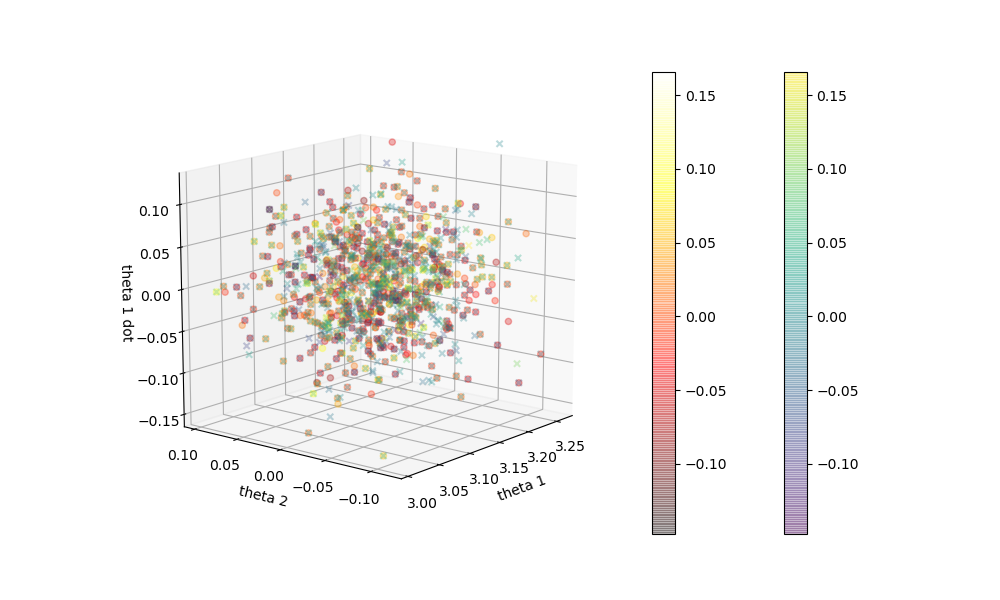

Text(0.5, 0, 'theta 1 dot')

In [26]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')

img = ax.scatter(points[:, 0], points[:, 1], points[:, 2], \
                 c = points[:, 3], marker='x', cmap='viridis', alpha=0.3)
fig.colorbar(img)

img2 = ax.scatter(points_new[:, 0], points_new[:, 1], points_new[:, 2], \
                  c = points_new[:, 3], marker='o', cmap = plt.hot(), alpha=0.3)
fig.colorbar(img2)

# img = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c = 'g', marker='o', alpha = 0.1)
# img2 = ax.scatter(points_new[:, 0], points_new[:, 1], points_new[:, 2], \
#                   c = 'b', marker='x', alpha=0.1)


ax.set_xlabel("theta 1")
ax.set_ylabel("theta 2")
ax.set_zlabel("theta 1 dot")

In [103]:
UprightState().CopyToVector() + 0.05 * np.random.randn(4,)

array([ 3.09582565,  0.00313207, -0.08825696,  0.07258637])

In [15]:
ACRO = AcrobotPlant()

In [16]:
def UprightState():
    state = AcrobotState()
    state.set_theta1(np.pi)
    state.set_theta2(0.)
    state.set_theta1dot(0.)
    state.set_theta2dot(0.)
    return state

context = ACRO.CreateDefaultContext()
input = AcrobotInput()
input.set_tau(0)
ACRO.get_input_port(0).FixValue(context, input)

context.get_mutable_continuous_state_vector().SetFromVector(UprightState().CopyToVector())

In [17]:
linearized_acro = Linearize(ACRO, context)

LQR = LinearQuadraticRegulator(linearized_acro.A(), linearized_acro.B(), Q, R)

In [18]:
LQR

(array([[-278.44223126, -112.29125985, -119.72457377,  -56.82824017]]),
 array([[16620.60660543,  7470.1873401 ,  7240.12368147,  3571.58116271],
        [ 7470.1873401 ,  3374.43640793,  3256.40272521,  1608.54161654],
        [ 7240.12368147,  3256.40272521,  3154.73036214,  1556.50607291],
        [ 3571.58116271,  1608.54161654,  1556.50607291,   768.33308414]]))

In [45]:
c = ACRO.get_mutable_state(context)

In [49]:
d = ACRO.get_state(context)

In [52]:
type(d)

pydrake.examples.acrobot.AcrobotState

In [53]:
type(c)

pydrake.examples.acrobot.AcrobotState

Getting Lyapunov function from closed loop controller

In [163]:
disturbance = np.linspace(0, 0.5, 200)

In [164]:
np.ones(5) * disturbance[3]

array([0.00753769, 0.00753769, 0.00753769, 0.00753769, 0.00753769])